In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

In [2]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

In [3]:
device = 'cuda'

In [4]:
df = pd.read_csv('../../../3OEC_current_flow.csv')

df["O2_avg"] = df[["O2_S1", "O2_S2", "O2_S3"]].mean(axis=1)

In [5]:
def MARE_np(prediction, truth):
    epsilon = 1e-8  # Small value to prevent division by zero
    return np.sum((np.abs(prediction - truth)) / np.abs(truth + epsilon)) / len(truth)

In [6]:
from datetime import datetime, timedelta

start_time_11 = datetime(2017, 7, 11, 14, 0, 0)
end_time_11 = datetime(2017, 7, 12, 8, 0, 0)

start_time_13 = datetime(2017, 7, 13, 11, 0, 0)
end_time_13 = datetime(2017, 7, 14, 6, 0, 0)

start_time_15 = datetime(2017, 7, 15, 10, 0, 0)
end_time_15 = datetime(2017, 7, 16, 6, 0, 0)

start_time_16 = datetime(2017, 7, 16, 16, 0, 0)
end_time_16 = datetime(2017, 7, 17, 6, 0, 0)

deployments = {
    "3oec_2017_7_11_12": {"start": start_time_11, "end": end_time_11},
    "3oec_2017_7_13_14": {"start": start_time_13, "end": end_time_13},
    "3oec_2017_7_15_16": {"start": start_time_15, "end": end_time_15},
    "3oec_2017_7_16_17": {"start": start_time_16, "end": end_time_16}
}

date_ranges = []

for deployment_name, deployment_info in deployments.items():
    start_time = deployment_info["start"]
    end_time = deployment_info["end"]
    if deployment_name == "3oec_2017_7_13_14":
        start_time -= timedelta(seconds=0.125)
    print(start_time)

    # Calculate total seconds and number of measurements
    total_seconds = (end_time - start_time).total_seconds() + 0.125
    num_measurements = int(total_seconds * 8)

    # Create DatetimeIndex for the deployment
    date_range = pd.date_range(start=start_time, periods=num_measurements, freq=f'{1000/8}ms')
    print(date_range[0], date_range[-1])
    print(len(date_range))
    date_ranges.append(pd.Series(date_range))

# Concatenate all DatetimeIndexes
complete_index = pd.concat(date_ranges)

# Set the complete index to your DataFrame
df.index = complete_index

2017-07-11 14:00:00
2017-07-11 14:00:00 2017-07-12 08:00:00
518401
2017-07-13 10:59:59.875000
2017-07-13 10:59:59.875000 2017-07-14 06:00:00
547202
2017-07-15 10:00:00
2017-07-15 10:00:00 2017-07-16 06:00:00
576001
2017-07-16 16:00:00
2017-07-16 16:00:00 2017-07-17 06:00:00
403201


In [7]:
# drop deployment column and resample
df_resampled = df.drop(columns=['deployment', 't', 't_increase', 'Vx', 'Vy', 'Vz', 'P', 'O2_S1', 'O2_S2', 'O2_S3']).resample('5min').mean()

In [8]:
first_piece = df_resampled["2017-07-11":"2017-07-12 06:00:00"]
second_piece = df_resampled["2017-07-13 12:00:00":"2017-07-14 06:00:00"]
third_piece = df_resampled["2017-07-15 12:00:00":"2017-07-16 6:00:00"]
fourth_piece = df_resampled["2017-07-16 16:00:00":"2017-07-17"]

In [9]:
def create_sequences(data, seq_length):
    """
    Creates sequences and their corresponding target sequences from the input data.
    The target sequence is half the size of the training sequence.

    Args:
        data (array-like): The input data.
        seq_length (int): The length of each training sequence.

    Returns:
        np.ndarray: Array of input sequences.
        np.ndarray: Array of target sequences (half the length of input sequences).
    """
    target_length = seq_length // 3  # Target is 1/3 the size of the training sequence

    if len(data) < seq_length + target_length:
        raise ValueError("Data length must be at least seq_length + target_length.")

    sequences = []
    targets = []
    
    for i in range(len(data) - seq_length - target_length + 1):
        sequences.append(data[i:i+seq_length])                        # Input sequence
        targets.append(data[i+seq_length:i+seq_length+target_length]) # Target sequence

    return np.array(sequences), np.array(targets)


In [10]:
# data piece 1

column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(first_piece)
train_df1 =first_piece

# Normalize the data (each partition separately)
train_mean1 = train_df1.mean()
train_std1 = train_df1.std()

train_df1 = (train_df1 - train_mean1) / train_std1


# make sequences
train_seq1, train_labels1 = create_sequences(train_df1.values, 90)


# make tensors
train_seq_tensor1 = torch.FloatTensor(train_seq1).to(device)  # (batch, seq_length, input_dim)
train_label_tensor1 = torch.FloatTensor(train_labels1).to(device) # (batch, output_dim)

In [11]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(second_piece)
train_df2 =second_piece

# Normalize the data (each partition separately)
train_mean2 = train_df2.mean()
train_std2 = train_df2.std()

train_df2 = (train_df2 - train_mean2) / train_std2

# make sequences
train_seq2, train_labels2 = create_sequences(train_df2.values, 90)

# make tensors
train_seq_tensor2 = torch.FloatTensor(train_seq2).to(device)  # (batch, seq_length, input_dim)
train_label_tensor2 = torch.FloatTensor(train_labels2).to(device) # (batch, output_dim)

In [12]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(third_piece)
train_df3 = third_piece

# Normalize the data (each partition separately)
train_mean3 = train_df3.mean()
train_std3 = train_df3.std()

train_df3 = (train_df3 - train_mean3) / train_std3

# make sequences
train_seq3, train_labels3 = create_sequences(train_df3.values, 90)

# make tensors
train_seq_tensor3 = torch.FloatTensor(train_seq3).to(device)  # (batch, seq_length, input_dim)
train_label_tensor3 = torch.FloatTensor(train_labels3).to(device) # (batch, output_dim)

In [13]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(fourth_piece)
train_df4 = fourth_piece

# Normalize the data (each partition separately)
train_mean4 = train_df4.mean()
train_std4 = train_df4.std()

train_df4 = (train_df4 - train_mean4) / train_std4

# make sequences
train_seq4, train_labels4 = create_sequences(train_df4.values, 90)

# make tensors
train_seq_tensor4 = torch.FloatTensor(train_seq4).to(device)  # (batch, seq_length, input_dim)
train_label_tensor4 = torch.FloatTensor(train_labels4).to(device) # (batch, output_dim)

In [14]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 30)
        # self.fc2 = nn.Linear(30, output_dim)
        # self.do = nn.Dropout()
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)  # Initial hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)  # Initial cell state
        
        out, _ = self.lstm(x, (h0, c0))
        # out = self.do(out)
        # print(out.shape)
        out = self.fc1(out[:,-1, :]) # take the last hidden state because we assume it encodes all the information about the sequence
        # out = self.fc2(out[, :])  # Take the last 30 time step output
        return out.unsqueeze(2)

# Model parameters
input_dim = 1
hidden_dim = 256
num_layers = 3
output_dim = 1

In [15]:
normalized_test_1 = (first_piece[:] - first_piece.mean())/first_piece.std()
test_seq_1, test_labels_1 = create_sequences(normalized_test_1.values, 90)
test_tensor_seq_1 = torch.FloatTensor(test_seq_1).to(device)
test_tensor_labels_1 = torch.FloatTensor(test_labels_1).to(device)

In [16]:
normalized_test_2 = (second_piece[:] - second_piece.mean())/second_piece.std()
test_seq_2, test_labels_2 = create_sequences(normalized_test_2.values, 90)
test_tensor_seq_2 = torch.FloatTensor(test_seq_2).to(device)
test_tensor_labels_2 = torch.FloatTensor(test_labels_2).to(device)

In [17]:
normalized_test_3 = (third_piece[:] - third_piece.mean())/third_piece.std()
test_seq_3, test_labels_3 = create_sequences(normalized_test_3.values, 90)
test_tensor_seq_3 = torch.FloatTensor(test_seq_3).to(device)
test_tensor_labels_3 = torch.FloatTensor(test_labels_3).to(device)

In [18]:
normalized_test_4 = (fourth_piece[:] - fourth_piece.mean())/fourth_piece.std()
test_seq_4, test_labels_4 = create_sequences(normalized_test_4.values, 90)
test_tensor_seq_4 = torch.FloatTensor(test_seq_4).to(device)
test_tensor_labels_4 = torch.FloatTensor(test_labels_4).to(device)

In [19]:
test_labels_1_un = test_labels_1 * first_piece.std().values + first_piece.mean().values
test_labels_2_un = test_labels_2 * second_piece.std().values + second_piece.mean().values
test_labels_3_un = test_labels_3 * third_piece.std().values + third_piece.mean().values
test_labels_4_un = test_labels_4 * fourth_piece.std().values + fourth_piece.mean().values

In [20]:
def fed_avg(models):
    global_model = models[0]
    avg_state_dict = global_model.state_dict()
    
    with torch.no_grad():
        for key in avg_state_dict.keys():
            avg_state_dict[key] = torch.stack([m.state_dict()[key] for m in models], dim=0).mean(dim=0)
    
    global_model.load_state_dict(avg_state_dict)
    return global_model


In [21]:
def fed_avg_weighted(models, client_ds_sizes):
    global_model = models[0]
    avg_state_dict = global_model.state_dict()

    total_ds_size = sum(client_ds_sizes)
    weights = [size / total_ds_size for size in client_ds_sizes]

    with torch.no_grad():
        for key in avg_state_dict.keys():
            avg_state_dict[key] = torch.stack([models[i].state_dict()[key] * weights[i] for i in range(len(models))], dim=0).sum(dim=0)

    global_model.load_state_dict(avg_state_dict)
    return global_model

In [22]:
def get_client_data():
    client_data=[0]*4
    client_labels=[0]*4

    client_data[0] = train_seq_tensor1
    client_labels[0] = train_label_tensor1

    client_data[1] = train_seq_tensor2
    client_labels[1] = train_label_tensor2

    client_data[2] = train_seq_tensor3
    client_labels[2] = train_label_tensor3

    client_data[3] = train_seq_tensor4
    client_labels[3] = train_seq_tensor4

    return client_data, client_labels    

### Initialize clients and perform training

In [23]:
rounds = 100
local_epochs = 10

global_model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim).to(device)
num_clients = 3

loss = torch.nn.SmoothL1Loss()
client_inputs, client_targets = get_client_data()

for round in range(rounds):
    print(f"\nFL Round {round+1}")
    local_models = []

    for i in range(num_clients):
        print(f"Client {i+1}")
        local_model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim).to(device)
        local_model.load_state_dict(global_model.state_dict())

        optimizer = optim.Adam(local_model.parameters(), lr=0.0001)
        local_model.train()

        for _ in range(local_epochs):
            inputs = client_inputs[i]
            targets = client_targets[i]
           
            optimizer.zero_grad()
            # forward pass
            y = local_model(inputs)
            error = loss(y, targets)
            # backward pass
            error.backward()
            optimizer.step()
        print(f"Client {i+1} Loss: {error.item()}")
        local_models.append(local_model)
    
    # aggregate
    global_model = fed_avg_weighted(local_models, [len(test_tensor_labels_1), len(test_tensor_labels_2), len(test_tensor_labels_3)])


FL Round 1
Client 1
Client 1 Loss: 0.3978082835674286
Client 2
Client 2 Loss: 0.39694762229919434
Client 3
Client 3 Loss: 0.38622066378593445

FL Round 2
Client 1
Client 1 Loss: 0.38679108023643494
Client 2
Client 2 Loss: 0.388306200504303
Client 3
Client 3 Loss: 0.3850831091403961

FL Round 3
Client 1
Client 1 Loss: 0.3681553602218628
Client 2
Client 2 Loss: 0.3737199306488037
Client 3
Client 3 Loss: 0.3831654191017151

FL Round 4
Client 1
Client 1 Loss: 0.3274407386779785
Client 2
Client 2 Loss: 0.34165871143341064
Client 3
Client 3 Loss: 0.3795849084854126

FL Round 5
Client 1
Client 1 Loss: 0.20792809128761292
Client 2
Client 2 Loss: 0.2434139996767044
Client 3
Client 3 Loss: 0.3703779876232147

FL Round 6
Client 1
Client 1 Loss: 0.06541791558265686
Client 2
Client 2 Loss: 0.13521194458007812
Client 3
Client 3 Loss: 0.339316725730896

FL Round 7
Client 1
Client 1 Loss: 0.031180188059806824
Client 2
Client 2 Loss: 0.09539944678544998
Client 3
Client 3 Loss: 0.3412404954433441

FL R

In [24]:
torch.save(global_model.state_dict(), 'models/fl_model_mutlistep123')

### Test on dataset 1

In [25]:
global_model.eval()
error = 0
n_sequences = len(test_tensor_seq_1)
for i in range(n_sequences):
    # ignore the last step since we don't have real data to compare with
    y_test_seq = test_tensor_seq_1[i]
    y_test_label = test_labels_1_un[i]
    y_pred_test = global_model(y_test_seq.unsqueeze(0))
    # un-normalize prediction and label
    y_pred_test = y_pred_test.squeeze(0).detach().cpu().numpy() * first_piece.std().values + first_piece.mean().values
    mare = MARE_np(y_pred_test, y_test_label).item()
    error += mare

avg_error = error/n_sequences
print(f'AVG error across sequences: {avg_error}')

AVG error across sequences: 0.0034093033719482402


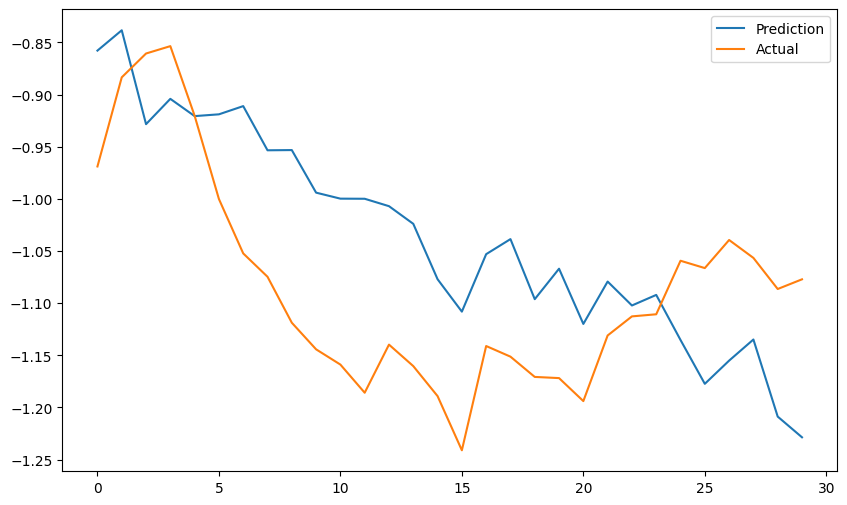

In [26]:
y_pred = global_model(test_tensor_seq_1[50].unsqueeze(0))
plt.figure(figsize=(10, 6))
plt.plot(y_pred.squeeze(0).detach().cpu().numpy(), label="Prediction")
plt.plot(test_tensor_labels_1[50].squeeze(0).cpu().numpy(), label="Actual")
plt.legend()
plt.show()

### Test on dataset 2

In [27]:
global_model.eval()
error = 0
n_sequences = len(test_tensor_seq_2)
for i in range(n_sequences):
    # ignore the last step since we don't have real data to compare with
    y_test_seq = test_tensor_seq_2[i]
    y_test_label = test_labels_2_un[i]
    y_pred_test = global_model(y_test_seq.unsqueeze(0))
    # un-normalize prediction and label
    y_pred_test = y_pred_test.squeeze(0).detach().cpu().numpy() * second_piece.std().values + second_piece.mean().values
    mare = MARE_np(y_pred_test, y_test_label).item()
    error += mare

avg_error = error/n_sequences
print(f'AVG error across sequences: {avg_error}')

AVG error across sequences: 0.0026825061552331855


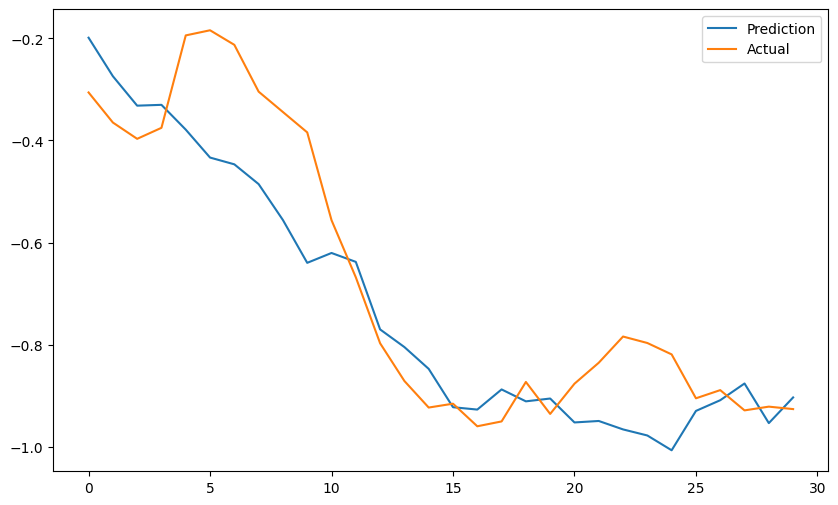

In [28]:
y_pred = global_model(test_tensor_seq_2[50].unsqueeze(0))
plt.figure(figsize=(10, 6))
plt.plot(y_pred.squeeze(0).detach().cpu().numpy(), label="Prediction")
plt.plot(test_tensor_labels_2[50].squeeze(0).cpu().numpy(), label="Actual")
plt.legend()
plt.show()

### Test on dataset 3

In [29]:
global_model.eval()
error = 0
n_sequences = len(test_tensor_seq_3)
for i in range(n_sequences):
    # ignore the last step since we don't have real data to compare with
    y_test_seq = test_tensor_seq_3[i]
    y_test_label = test_labels_3_un[i]
    y_pred_test = global_model(y_test_seq.unsqueeze(0))
    # un-normalize prediction and label
    y_pred_test = y_pred_test.squeeze(0).detach().cpu().numpy() * third_piece.std().values + third_piece.mean().values
    mare = MARE_np(y_pred_test, y_test_label).item()
    error += mare

avg_error = error/n_sequences
print(f'AVG error across sequences: {avg_error}')

AVG error across sequences: 0.00322468319578698


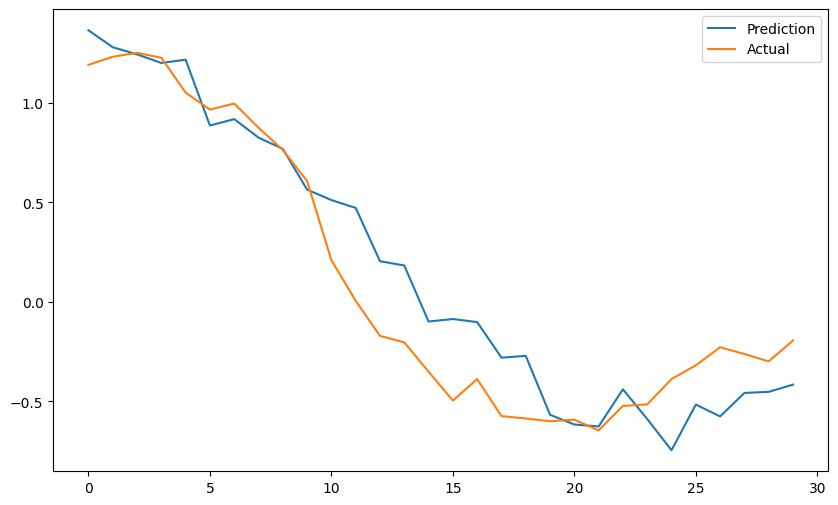

In [30]:
y_pred = global_model(test_tensor_seq_3[50].unsqueeze(0))
plt.figure(figsize=(10, 6))
plt.plot(y_pred.squeeze(0).detach().cpu().numpy(), label="Prediction")
plt.plot(test_tensor_labels_3[50].squeeze(0).cpu().numpy(), label="Actual")
plt.legend()
plt.show()

### Test on dataset 4

In [31]:
global_model.eval()
error = 0
n_sequences = len(test_tensor_seq_4)
for i in range(n_sequences):
    # ignore the last step since we don't have real data to compare with
    y_test_seq = test_tensor_seq_4[i]
    y_test_label = test_labels_4_un[i]
    y_pred_test = global_model(y_test_seq.unsqueeze(0))
    # un-normalize prediction and label
    y_pred_test = y_pred_test.squeeze(0).detach().cpu().numpy() * fourth_piece.std().values + fourth_piece.mean().values
    mare = MARE_np(y_pred_test, y_test_label).item()
    error += mare

avg_error = error/n_sequences
print(f'AVG error across sequences: {avg_error}')

AVG error across sequences: 0.007414862565817767


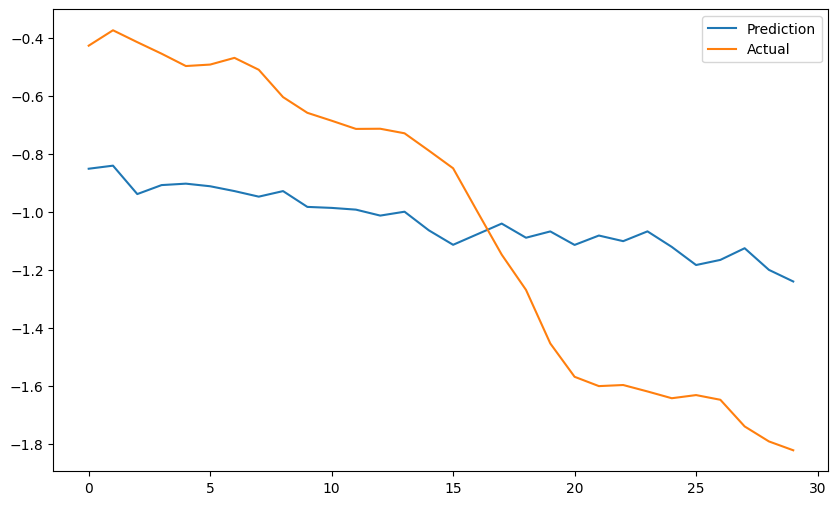

In [32]:
y_pred = global_model(test_tensor_seq_4[40].unsqueeze(0))
plt.figure(figsize=(10, 6))
plt.plot(y_pred.squeeze(0).detach().cpu().numpy(), label="Prediction")
plt.plot(test_tensor_labels_4[40].squeeze(0).cpu().numpy(), label="Actual")
plt.legend()
plt.show()